In [1]:
import pandas as pd
import numpy as np
import scipy
import unicodedata
import re
import contractions
import string
import distance
import glob
import joblib,pickle

#vis
#http://brandonrose.org/clustering
#https://medium.com/analytics-vidhya/machine-learning-4-unsupervised-learning-clustering-k-means-algorithm-dimensional-reduction-238a54e8cfcd

import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm import tnrange


## for sentiment
from textblob import TextBlob

# from bokeh.plotting import figure, show, output_notebook, output_file, save
# from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
# from bokeh.palettes import Category10,Category20

from wordcloud import WordCloud, ImageColorGenerator
from scipy.ndimage import gaussian_gradient_magnitude


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split

#spacy
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")
nlp2 = spacy.load("en_core_web_md")
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
import textwrap
stops = stopwords.words('english')
new_stopwords = ["data","create","configure","cluster"]
stops.extend(new_stopwords)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [135]:
df = pd.read_csv('cleaned_data.csv')
df.shape

(3280, 6)

In [136]:
# def remove_shorter_query(data,column,n):
#     data[column] = data[column].apply(lambda x:str(x).split(' '))
#     data = data[data[column].apply(lambda x:True if len(x) > n else False)]
#     data[column] = data[column].apply(lambda x:' '.join(x))
#     data = data.reset_index()
#     del data["index"]
    
#     return data

In [137]:
# df = remove_shorter_query(df,"search_text",1)

In [154]:
df.head()

,index_type,title,url,search_text,description,breadcrumb
0,gcp_docs,Workflows with jobs,https://docs.gcp.databricks.com/data-engineeri...,workflows with jobs,Workflows with jobs You can use a job to run a...,['Databricks Data Science & Engineering guide'...
1,gcp_docs,Workflows with jobs,https://docs.gcp.databricks.com/data-engineeri...,workflows with jobs,Workflows with jobs You can use a job to run a...,['Databricks Data Science & Engineering guide'...
2,gcp_docs,Workflows with jobs,https://docs.gcp.databricks.com/data-engineeri...,monitoring,Workflows with jobs You can use a job to run a...,['Databricks Data Science & Engineering guide'...
3,gcp_docs,Workflows with jobs,https://docs.gcp.databricks.com/data-engineeri...,workflows,Workflows with jobs You can use a job to run a...,['Databricks Data Science & Engineering guide'...
4,gcp_docs,Workflows with jobs,https://docs.gcp.databricks.com/data-engineeri...,jobs,Workflows with jobs You can use a job to run a...,['Databricks Data Science & Engineering guide'...


In [139]:
# Group by page
grouped_df = df.groupby(['url']).agg({'search_text':list})
 
# Join all queries in a single string
#https://bobbyhadz.com/blog/python-typeerror-sequence-item-0-expected-str-instance-float-found
grouped_df['queries'] = grouped_df['search_text'].apply(lambda x: ' '.join(map(str,x)))
# grouped_df['description'] = grouped_df['description'].apply(lambda x: ' '.join(map(str,x)))
 
# Create a list of grouped queries
# for each page. 
queries = list(grouped_df['queries'])

In [140]:
tfidf_vec =  TfidfVectorizer(min_df=0.05, max_df=0.6,
                                                     stop_words=stops,
                                                     ngram_range=(1,2)
                                                     )
data_tfidf = tfidf_vec.fit_transform(queries).todense()
tfidf_df = pd.DataFrame(
    data_tfidf,
    columns=tfidf_vec.get_feature_names(),
    index=grouped_df.index
    )
 
tfidf_df

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,databricks,delta,sql,table
url,,,,
https://docs.gcp.databricks.com/,0.0,1.0,0.0,0.0
https://docs.gcp.databricks.com/_static/notebooks/mlflow/mlflow-end-to-end-example.html,0.0,0.0,0.0,0.0
https://docs.gcp.databricks.com/administration-guide/access-control/cluster-acl.html,0.0,0.0,0.0,0.0
https://docs.gcp.databricks.com/administration-guide/access-control/index.html,0.0,0.0,0.0,0.0
https://docs.gcp.databricks.com/administration-guide/access-control/table-acl.html,0.0,0.0,0.0,0.0
...,...,...,...,...
https://kb.databricks.com/en_US/python/running-c-plus-plus-code,0.0,0.0,0.0,0.0
https://kb.databricks.com/en_US/scala/running-c-plus-plus-code-scala,0.0,0.0,0.0,0.0
https://kb.databricks.com/en_US/sql/error-download-full-results,0.0,0.0,0.0,0.0


In [141]:
pca = PCA( 0.95, random_state=2140)
data_pca = pca.fit_transform(data_tfidf)

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


# Clustering with K-means
Selecting number of clusters

In [142]:
cluster_sizes = range(2, 20+1)
kmeans_models = [ KMeans(i, n_init=20, random_state=2140) for i in cluster_sizes ]
cluster_score = []

for kmeans in kmeans_models:
    y = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, y)
    cluster_score.append( ( kmeans.n_clusters, score) )

cluster_score=np.array(cluster_score)

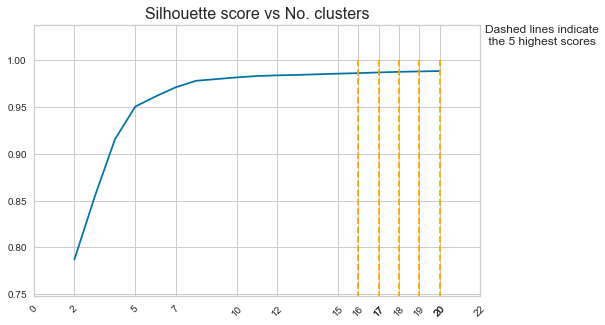

In [143]:
scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots( figsize=(8,5) )
ax = sns.lineplot( x=clusters, y=scores, ax=ax )
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort( scores )[-5:]:
  ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
  max_score_clusters.append( clusters[i] )

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim( [ 0.95*min(scores), 1.05*max(scores) ] )
ax.set_xlim( [ 0, max(clusters)+2 ] )

plt.show()

In [144]:
n_clusters= 7
kmeans_model = KMeans(n_clusters =7, n_init=20, random_state=2140)
y = kmeans_model.fit_predict(data_pca)

# Results visualization
Silhouette samples

In [145]:
sample_scores = silhouette_samples( data_pca, y )
sample_scores_df =  pd.DataFrame( data = {'Cluster':y, 'Silhouette':sample_scores} )
sample_scores_df = sample_scores_df.reset_index()
sample_scores_df=sample_scores_df.sort_values('Silhouette', ascending=False)

In [146]:
sample_scores_df

,index,Cluster,Silhouette
819,819,2,1.000000
847,847,2,1.000000
759,759,2,1.000000
853,853,2,1.000000
852,852,2,1.000000
...,...,...,...
616,616,4,0.107119
371,371,5,0.071726
379,379,4,0.047695
631,631,4,0.047695


In [147]:
kmeans_pca_scale = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(data_pca)

In [148]:
# assign predicted clusters
labels = kmeans_pca_scale.labels_
#print(len(labels)) 
# create a dataframe that contains 
# clusters matched to pages and their queries 
mapping = list(zip(labels, grouped_df.index, queries))
clusters = pd.DataFrame(mapping, columns=['cluster','url','search_text'])
clusters.head()
clusters.head(10)

,cluster,url,search_text
0,4,https://docs.gcp.databricks.com/,delta lake and delta engine guide streaming io...
1,0,https://docs.gcp.databricks.com/_static/notebo...,10.5 ml
2,0,https://docs.gcp.databricks.com/administration...,no active google kubernetes engine cluster fou...
3,0,https://docs.gcp.databricks.com/administration...,workspaces acl
4,0,https://docs.gcp.databricks.com/administration...,premium premium dlt
5,0,https://docs.gcp.databricks.com/administration...,token management personal access token token p...
6,0,https://docs.gcp.databricks.com/administration...,terraform
7,0,https://docs.gcp.databricks.com/administration...,account console account console account consol...
8,0,https://docs.gcp.databricks.com/administration...,cancel free trail on google cloud platform can...
9,0,https://docs.gcp.databricks.com/administration...,account delegated authentication accounts api


In [149]:
clusters.cluster.value_counts()

0    867
1     75
4     40
6     36
3     34
5     20
2     15
Name: cluster, dtype: int64

# BIGRAMS

In [150]:
def find_bigrams(input_list):
    return list(zip(input_list, input_list[1:]))


In [151]:
from nltk import pos_tag, word_tokenize

In [152]:
from collections import Counter
from nltk.tokenize import word_tokenize
 
my_dict1 = {}
n_clusters = clusters['cluster'].unique()
n=3 
# for each cluster
for c in n_clusters: 
    # 1
    asset = clusters[clusters['cluster'] == c] 
    asset = asset['search_text']
    m_asset = ' '.join(asset)
    # 2
    tokens = word_tokenize(m_asset)
    # 3
    words = [word for word in tokens if not word in stops]
    # 4
    bigrams = find_bigrams(words)
    bigrams = list(map(' '.join, bigrams))
    # 5
    counts = Counter(bigrams)
    # 6
    most_common = counts.most_common(4)
    most_freq = [bigram[0] for bigram in most_common]
    # 7
    my_dict1[c] = ','.join(most_freq)
     
my_dict1

{4: 'delta live,live tables,bigquery bigquery,tables delta',
 0: 'service account,unity catalog,audit log,scim scim',
 1: 'rest api,dbfs dbfs,databricks cli,secrets secrets',
 6: 'access control,table access,table table,parquet file',
 2: 'delta table,delta live,live table,table delta',
 3: 'sql endpoint,sql server,sql sql,insert sql',
 5: 'databricks sql,( databricks,sql ),sql databricks'}

In [115]:
clusters.to_csv('databricks-class.csv',index=False)

In [153]:
show_k = 4
 
print('Cluster number: ', show_k)
print('\nTop bigrams: ')
print(my_dict1[show_k])
print('\nTitles in the cluster: ')
pages = clusters['search_text'][clusters['cluster'] == show_k]
for page in pages:
    print(page)

Cluster number:  4

Top bigrams: 
delta live,live tables,bigquery bigquery,tables delta

Titles in the cluster: 
delta lake and delta engine guide streaming iot core to cloud storage autoloader gke
data live tables delta live tables delta live tables delta live delta live tables delta live tables delta live tables live table materialized views latency
delta live tables dlt import dlt
delta live
delta live tables drop
delta live live table delta live tables delta live tables delta live table live tables delta live table delta live tables delta live tables delta live tables delta live tables delta live tables live tables delta live table live t delta live delta live great expectations delta live tables delta live
com.google.cloud.spark.bigquery.repackaged.com.google.inject.provision exception: unable to provision, see the following errors: details for job jobs com.google.cloud.spark.bigquery.repackaged.com.google.inject.provision exception: unable to provision, see the following errors: 